### Surrogate Model Comparison
| Model        |    RMSE |     MAE |       R2 |
|:-------------|--------:|--------:|---------:|
| RandomForest | 5.22782 | 4.1849  | 0.924038 |
| MLPRegressor | 5.03219 | 4.04705 | 0.929617 |
| HybridStack  | 5.00892 | 4.02959 | 0.930266 |


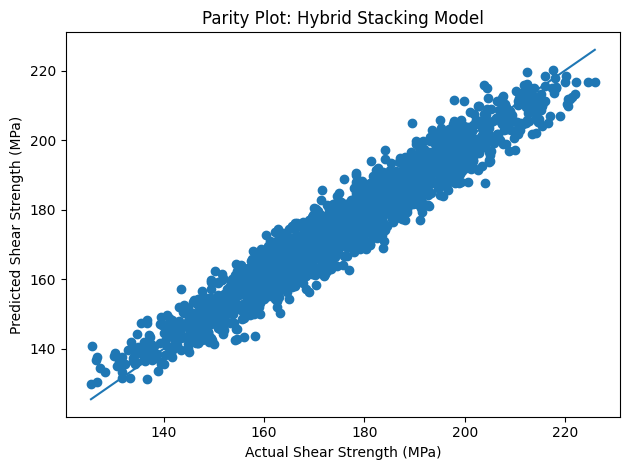

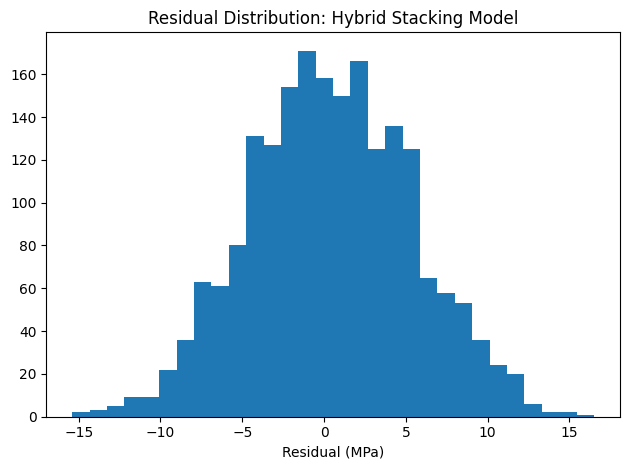

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from pandas.plotting import scatter_matrix

# 1. Load data
df = pd.read_csv('shear_data.csv')
X = df[['thickness_mm', 'extrusion_ratio', 'SiC_wt%', 'hardening_slope_MPa_per_mm']]
y = df['shear_strength_MPa']

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Base models
rf = RandomForestRegressor(n_estimators=200, random_state=42)
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

rf.fit(X_train, y_train)
mlp.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_pred_mlp = mlp.predict(X_test)

# 4. Hybrid stacking model
stack = StackingRegressor(
    estimators=[('rf', rf), ('mlp', mlp)],
    final_estimator=LinearRegression()
)
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)

# 5. Compute metrics
models = {
    'RandomForest': y_pred_rf,
    'MLPRegressor': y_pred_mlp,
    'HybridStack': y_pred_stack
}
metrics = []
for name, y_pred in models.items():
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    metrics.append({'Model': name, 'RMSE': rmse, 'MAE': mae, 'R2': r2})

metrics_df = pd.DataFrame(metrics)

# Display metrics table
print("### Surrogate Model Comparison")
print(metrics_df.to_markdown(index=False))

# 6. Parity plot for HybridStack
plt.figure()
plt.scatter(y_test, y_pred_stack)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel('Actual Shear Strength (MPa)')
plt.ylabel('Predicted Shear Strength (MPa)')
plt.title('Parity Plot: Hybrid Stacking Model')
plt.tight_layout()
plt.show()

# 7. Residual distribution for HybridStack
residuals = y_test - y_pred_stack
plt.figure()
plt.hist(residuals, bins=30)
plt.xlabel('Residual (MPa)')
plt.title('Residual Distribution: Hybrid Stacking Model')
plt.tight_layout()
plt.show()


In [12]:
metrics_df

,Model,RMSE,MAE,R2
0,RandomForest,5.227825,4.184903,0.924038
1,MLPRegressor,5.032192,4.047054,0.929617
2,HybridStack,5.008924,4.029592,0.930266


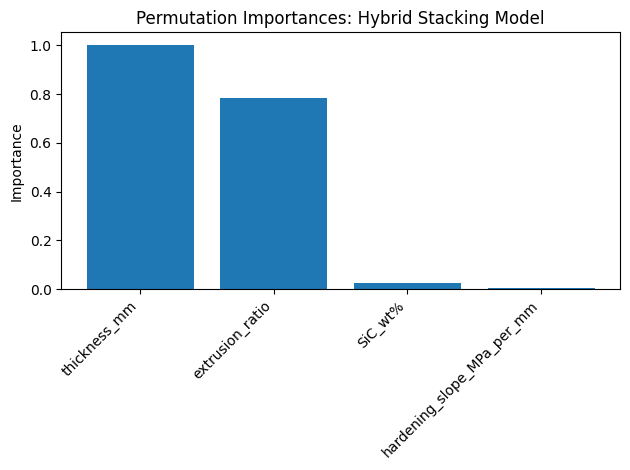

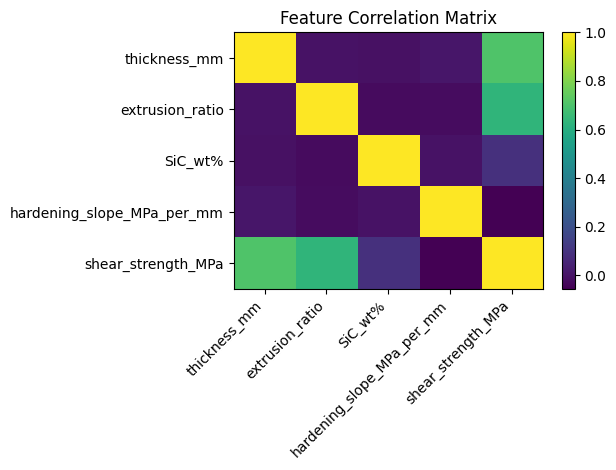

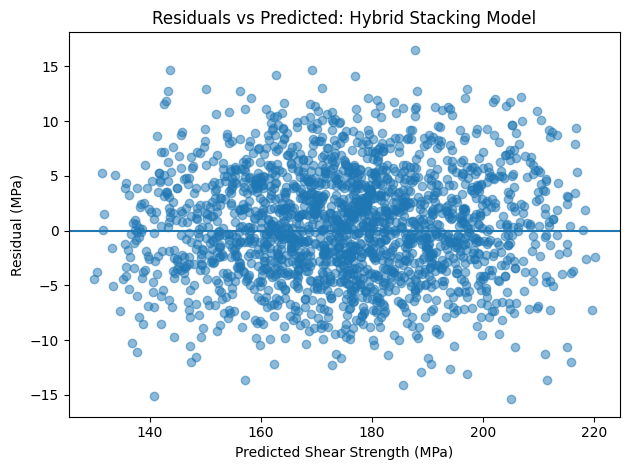

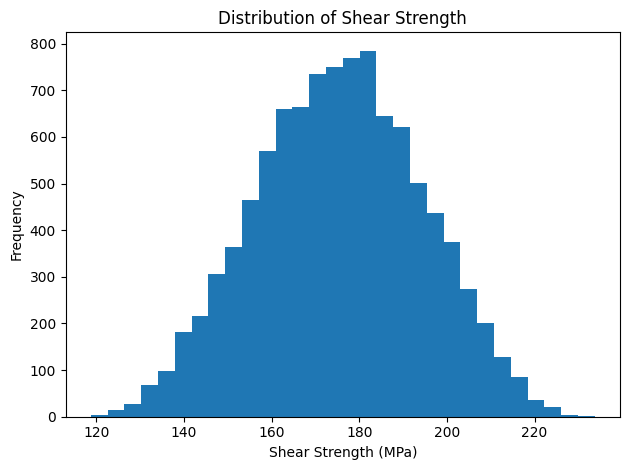

In [15]:
df = pd.read_csv('shear_data.csv')
X = df[['thickness_mm', 'extrusion_ratio', 'SiC_wt%', 'hardening_slope_MPa_per_mm']]
y = df['shear_strength_MPa']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)
mlp = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=500, random_state=42).fit(X_train, y_train)
stack = StackingRegressor(
    estimators=[('rf', rf), ('mlp', mlp)],
    final_estimator=LinearRegression()
).fit(X_train, y_train)

# Predictions & residuals
y_pred = stack.predict(X_test)
residuals = y_test - y_pred

# 1) Permutation importances for HybridStack
perm = permutation_importance(stack, X_test, y_test, n_repeats=10, random_state=42)
importances = perm.importances_mean
indices = np.argsort(importances)[::-1]
fig, ax = plt.subplots()
ax.bar(range(X.shape[1]), importances[indices])
ax.set_xticks(range(X.shape[1]))
ax.set_xticklabels(X.columns[indices], rotation=45, ha='right')
ax.set_ylabel('Importance')
ax.set_title('Permutation Importances: Hybrid Stacking Model')
plt.tight_layout()
plt.show()

# 2) Correlation matrix heatmap
corr = df.corr()
fig, ax = plt.subplots()
cax = ax.imshow(corr, aspect='auto')
ax.set_xticks(range(len(corr)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticks(range(len(corr)))
ax.set_yticklabels(corr.index)
fig.colorbar(cax, ax=ax)
ax.set_title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# 3) Residuals vs Predicted
fig, ax = plt.subplots()
ax.scatter(y_pred, residuals, alpha=0.5)
ax.axhline(0)
ax.set_xlabel('Predicted Shear Strength (MPa)')
ax.set_ylabel('Residual (MPa)')
ax.set_title('Residuals vs Predicted: Hybrid Stacking Model')
plt.tight_layout()
plt.show()

# 4) Distribution of target variable
fig, ax = plt.subplots()
ax.hist(y, bins=30)
ax.set_xlabel('Shear Strength (MPa)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Shear Strength')
plt.tight_layout()
plt.show()

# # 5) Scatter matrix of features + target
# fig = scatter_matrix(df[['thickness_mm','extrusion_ratio','SiC_wt%','hardening_slope_MPa_per_mm','shear_strength_MPa']],
#                      alpha=0.2, diagonal='hist', figsize=(8,8))
# plt.tight_layout()
# plt.show()